In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image   
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:
# Pretty display for notebooks
%matplotlib inline

In [3]:
DATA_DIR = "input/imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [4]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

In [5]:
#Data Preparation
#We will create a csv file having the location of the files present for training and test images and their associated class if present so that it is easily traceable.

In [6]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)
    return

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))

In [7]:
data_train.head(5)

,Filename,ClassName
0,input/imgs/train/c7/img_62010.jpg,c7
1,input/imgs/train/c7/img_70414.jpg,c7
2,input/imgs/train/c7/img_96185.jpg,c7
3,input/imgs/train/c7/img_36333.jpg,c7
4,input/imgs/train/c7/img_73647.jpg,c7


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [9]:
# data_train.sort_values(by ='ClassName', inplace = True)

In [10]:
data_train['ClassName'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: ClassName, dtype: int64

In [11]:
data_train['ClassName']

0        c7
1        c7
2        c7
3        c7
4        c7
         ..
22419    c2
22420    c2
22421    c2
22422    c2
22423    c2
Name: ClassName, Length: 22424, dtype: object

In [12]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,input/imgs/train/c2/img_4253.jpg,c0
freq,1,2489


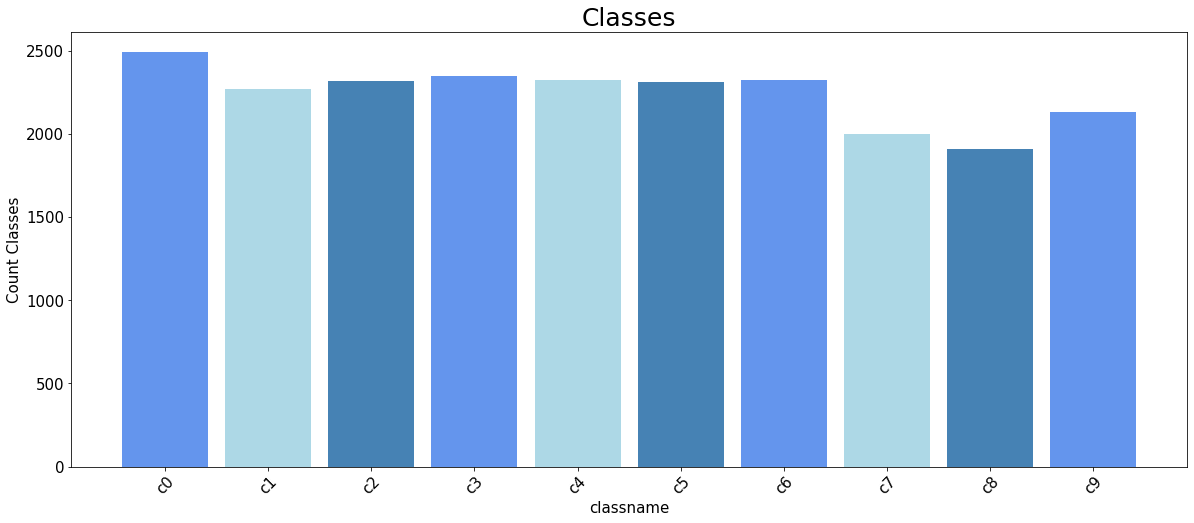

In [13]:
#sort the index to start from c0 to c9
data_train = data_train.sort_index()
counts = data_train['ClassName'].value_counts(sort=False).sort_index()
labels = data_train['ClassName'].value_counts().sort_index().index.tolist()
y = np.array(counts)
width = 1/1.2
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,8))
plt.xticks(x, labels, size=15)
plt.yticks(size=15)
plt.bar(x, y, width, color=['cornflowerblue', 'lightblue', 'steelblue'])
plt.title('Classes',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count Classes',size=15)
plt.xticks(rotation = 45)
plt.xticks(rotation=45)
plt.show()


In [14]:
data_test.head()

,FileName,ClassName
0,input/imgs/test/img_60161.jpg,test
1,input/imgs/test/img_94786.jpg,test
2,input/imgs/test/img_85853.jpg,test
3,input/imgs/test/img_36327.jpg,test
4,input/imgs/test/img_39014.jpg,test


In [15]:
data_test.shape

(79726, 2)

In [16]:
#Convert into numerical values
labels_list = sorted(set(data_train['ClassName'].values.tolist()))
print(labels_list)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [17]:
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)

{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [18]:
data_train['ClassName'].replace(labels_id,inplace=True)

In [19]:
data_train
# data_train.sort_values(by = 'ClassName', ascending = True)

,Filename,ClassName
0,input/imgs/train/c7/img_62010.jpg,7
1,input/imgs/train/c7/img_70414.jpg,7
2,input/imgs/train/c7/img_96185.jpg,7
3,input/imgs/train/c7/img_36333.jpg,7
4,input/imgs/train/c7/img_73647.jpg,7
...,...,...
22419,input/imgs/train/c2/img_52690.jpg,2
22420,input/imgs/train/c2/img_59935.jpg,2
22421,input/imgs/train/c2/img_75207.jpg,2
22422,input/imgs/train/c2/img_33252.jpg,2


In [20]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [21]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


In [22]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [23]:
xtrain.shape

(17939,)

In [24]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [25]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
# train_tensors = paths_to_tensor(xtrain)
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|██████████| 17939/17939 [01:56<00:00, 153.67it/s]


In [26]:
train_tensors.shape

(17939, 64, 64, 3)

In [27]:
#valid_tensors = paths_to_tensor(xtest)
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:27<00:00, 160.38it/s]


In [28]:
valid_tensors.shape

(4485, 64, 64, 3)

In [29]:
##takes too much ram 
## run this if your ram is greater than 16gb 
# test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5 

In [30]:
#Defining the model

In [31]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       131328    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         5

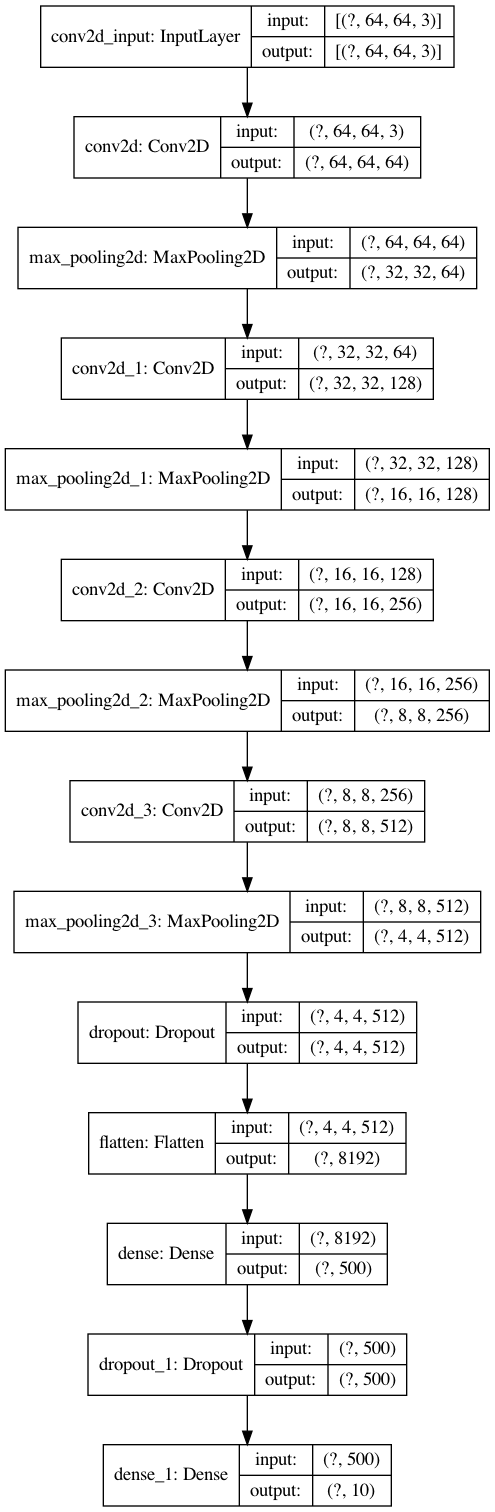

In [32]:
plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [35]:
#Augment the image data
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(train_tensors, ytrain, batch_size = 40)

In [36]:
# Fits the model on batches with real-time data augmentation:
model_history = model.fit(data_generator,steps_per_epoch = len(train_tensors) / 40, callbacks=callbacks_list,
                                                            epochs = 40, validation_data = (valid_tensors, ytest),shuffle=True)

# model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=10, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/40
449/448 [==============================] - ETA: 0s - loss: 2.2610 - accuracy: 0.1339
Epoch 00001: val_accuracy improved from -inf to 0.23411, saving model to /Users/danielchang/ds/Computer Vision/model/self_trained/distracted-01-0.23.hdf5
449/448 [==============================] - 269s 600ms/step - loss: 2.2610 - accuracy: 0.1339 - val_loss: 1.9778 - val_accuracy: 0.2341
Epoch 2/40
449/448 [==============================] - ETA: 0s - loss: 2.0964 - accuracy: 0.2037
Epoch 00002: val_accuracy improved from 0.23411 to 0.29588, saving model to /Users/danielchang/ds/Computer Vision/model/self_trained/distracted-02-0.30.hdf5
449/448 [==============================] - 259s 577ms/step - loss: 2.0964 - accuracy: 0.2037 - val_loss: 1.7131 - val_accuracy: 0.2959
Epoch 3/40
449/448 [==============================] - ETA: 0s - loss: 1.9150 - accuracy: 0.2673
Epoch 00003: val_accuracy improved from 0.29588 to 0.44013, saving model to /Users/danielchang/ds/Computer Vision/model/self_traine

Epoch 24/40
449/448 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.7055
Epoch 00024: val_accuracy improved from 0.90167 to 0.90479, saving model to /Users/danielchang/ds/Computer Vision/model/self_trained/distracted-24-0.90.hdf5
449/448 [==============================] - 263s 585ms/step - loss: 0.8367 - accuracy: 0.7055 - val_loss: 0.3303 - val_accuracy: 0.9048
Epoch 25/40
449/448 [==============================] - ETA: 0s - loss: 0.8336 - accuracy: 0.7096
Epoch 00025: val_accuracy improved from 0.90479 to 0.91327, saving model to /Users/danielchang/ds/Computer Vision/model/self_trained/distracted-25-0.91.hdf5
449/448 [==============================] - 267s 594ms/step - loss: 0.8336 - accuracy: 0.7096 - val_loss: 0.2866 - val_accuracy: 0.9133
Epoch 26/40
449/448 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.7172
Epoch 00026: val_accuracy improved from 0.91327 to 0.92129, saving model to /Users/danielchang/ds/Computer Vision/model/self_

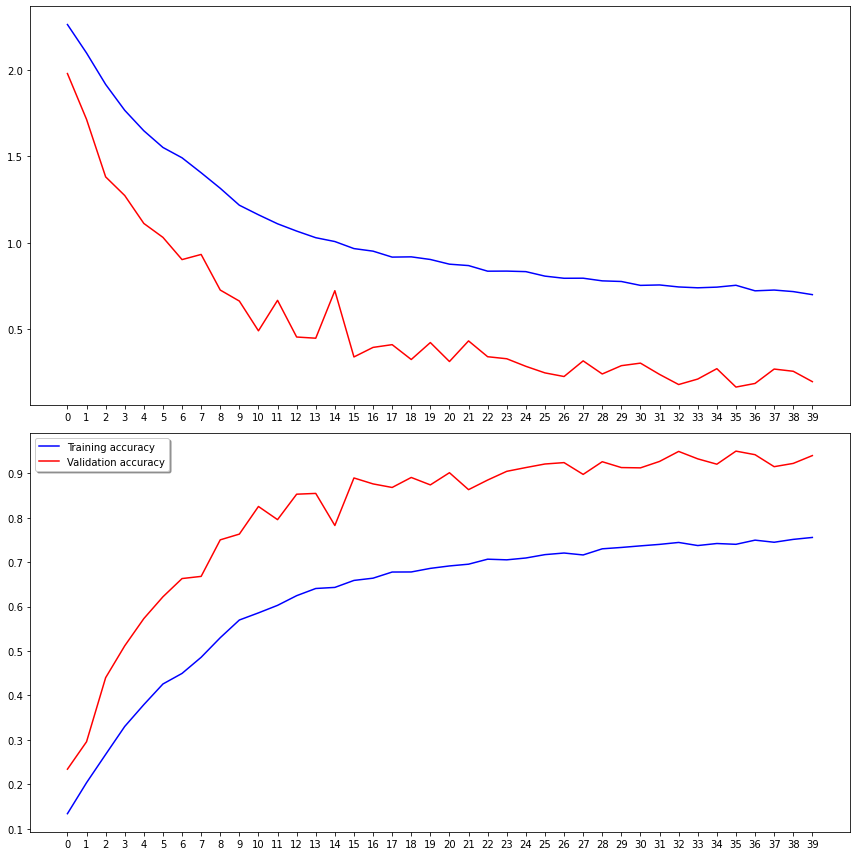

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(0, 40, 1))


ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(0, 40, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [38]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [39]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [40]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = model.predict(valid_tensors)

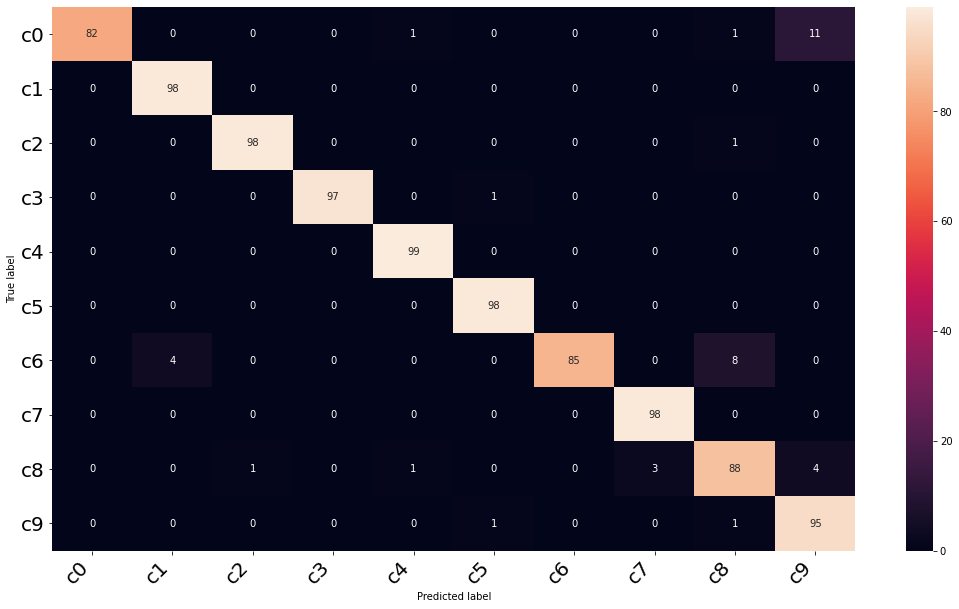

In [41]:
print_heatmap(ytest,ypred,class_names)

In [42]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [43]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.940245
Precision: 0.943583
Recall: 0.940245
F1 score: 0.940051


In [53]:
### Check data integrity
### Classes:
# c0: safe driving 
# c1: texting - right
# c2: talking on the phone - right
# c3: texting - left
# c4: talking on the phone - left
# c5: operating the radio
# c6: drinking
# c7: reaching behind
# c8: hair and makeup
# c9: talking to passenger